In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/cte-ml-hack-2019/train_real.csv
/kaggle/input/cte-ml-hack-2019/sample_submission.csv
/kaggle/input/cte-ml-hack-2019/test_real.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/cte-ml-hack-2019/train_real.csv')
test_df = pd.read_csv('/kaggle/input/cte-ml-hack-2019/test_real.csv')

# Train-Test split
# 
# Here we split train_df into train and validation dataframes

In [3]:
train_df["Azimuthal_angle"] = np.sqrt(train_df["Azimuthal_angle"])

train_df["H_dist_Hydro"] = np.sqrt(train_df["H_dist_Hydro"])

train_df["Dist_Hydro"] = np.sqrt((train_df["H_dist_Hydro"]**2 + train_df["V_dist_Hydro"]**2))
test_df["Dist_Hydro"] = np.sqrt((test_df["H_dist_Hydro"]**2 + test_df["V_dist_Hydro"]**2))

train_df['Dist_Hydro'] = np.sqrt(train_df['Dist_Hydro'])

train_df["H_dist_Fire"] = np.sqrt(train_df["H_dist_Fire"])

train_df["H_dist_Road"] = np.sqrt(train_df["H_dist_Road"])

train_df["Incline"] = np.sqrt(train_df["Incline"])

train_df['Hillshade_9am'] = (train_df['Hillshade_9am'])**3

train_df = train_df.drop(train_df[(train_df['Azimuthal_angle']>25)].index)
train_df = train_df.reset_index(drop = True)
train_df = train_df.drop(train_df[(train_df['H_dist_Hydro']<5)].index)
train_df = train_df.reset_index(drop = True)

X = train_df.drop(['Id', 'label','Soil','V_dist_Hydro'], axis=1)
y = train_df['label']

X_test = test_df.drop(['Id','Soil','V_dist_Hydro'], axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
y_train.head()

5227   -1
6425   -1
1737   -1
2318   -1
1158   -1
Name: label, dtype: int64

In [5]:
X_train.head()

,Altitude,Azimuthal_angle,Incline,H_dist_Hydro,H_dist_Road,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,H_dist_Fire,Wilderness_Area_A,Wilderness_Area_B,Wilderness_Area_C,Wilderness_Area_D,Dist_Hydro
5227,364,24.535688,5.477226,11.704700,5.196152,620650477,948,633,29.034462,1,0,0,0,14.639667
6425,488,7.615773,13.490738,15.556349,18.627936,580093704,838,539,15.524175,0,0,1,0,18.175986
1737,600,19.723083,15.066519,10.344080,22.090722,851971392,920,468,27.386128,1,0,0,0,14.568878
2318,448,12.369317,21.307276,17.944358,11.832160,674526133,641,208,16.522712,0,0,1,0,17.104118
1158,639,20.199010,16.492423,22.693611,11.874342,862801408,924,452,16.763055,0,0,1,0,18.674559


# EDA
# This is where we start to explore the data and the features to see if we can apply some algorithms to the features to make them more usable for our model

In [6]:
#Just checking features for any unnaturally high skewness

print(train_df.skew())

Id                   0.022926
Altitude            -0.734872
Azimuthal_angle     -0.334767
Incline             -0.003353
H_dist_Hydro         0.450596
V_dist_Hydro         1.590253
H_dist_Road          0.095889
Hillshade_9am       -0.338221
Hillshade_Noon      -0.913251
Hillshade_3pm       -0.766315
H_dist_Fire          0.355927
Wilderness_Area_A    0.030440
Wilderness_Area_B    4.485959
Wilderness_Area_C    0.320422
Wilderness_Area_D    4.485959
label                1.761686
Dist_Hydro           1.045959
dtype: float64


In [7]:
# Correlation tells relation between two attributes.
# Correlation requires continous data. Hence, ignore Wilderness_Area and Soil_Type as they are binary

#Index where continuous data ends
size = 10

data=train_df.iloc[:,:size] 

cols=data.columns 

data_corr = data.corr()

threshold = 0.5

corr_list = []

for i in range(0,size):
    for j in range(i+1,size):
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) 

s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

Hillshade_Noon and Hillshade_3pm = 0.75
Hillshade_9am and Hillshade_3pm = -0.62
Azimuthal_angle and Hillshade_Noon = 0.61
H_dist_Hydro and V_dist_Hydro = 0.56
Incline and Hillshade_3pm = -0.55
Incline and Hillshade_Noon = -0.52


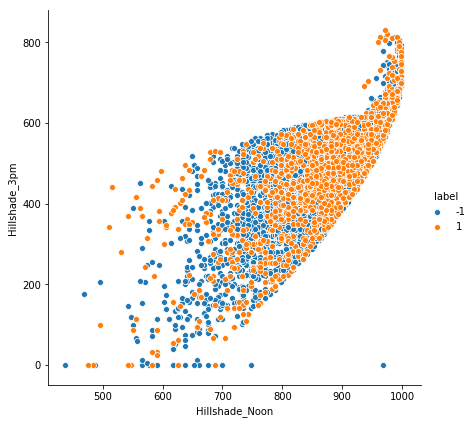

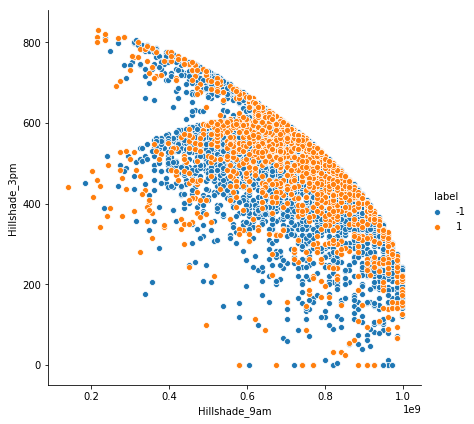

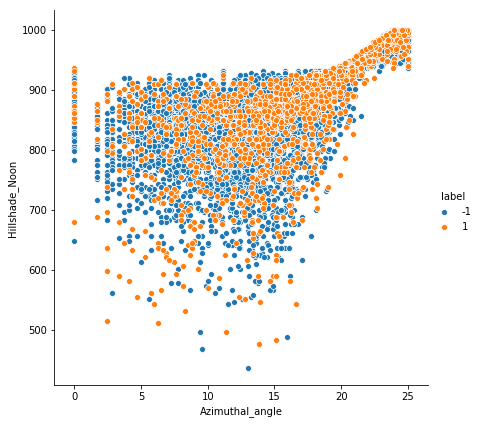

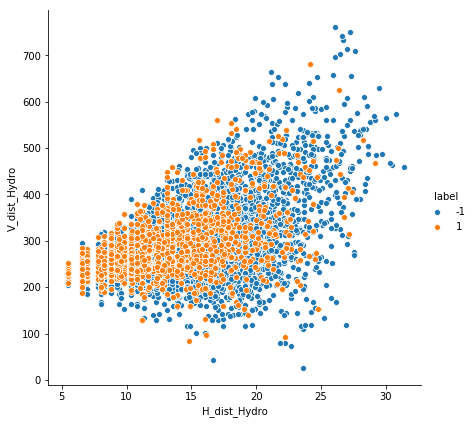

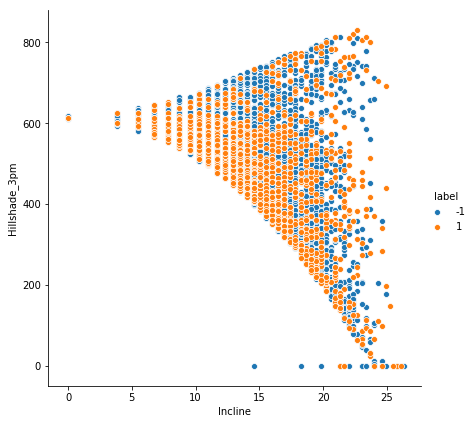

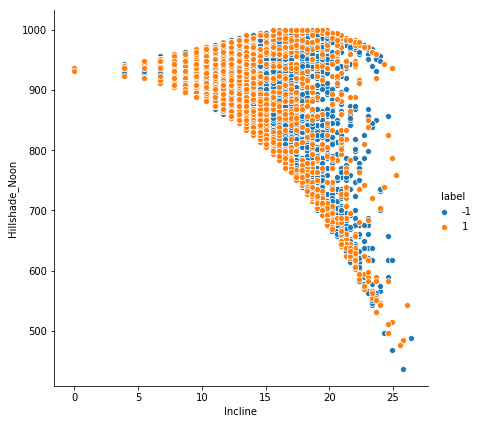

In [8]:
#Plotting the features with high correlation along with the labels
for v,i,j in s_corr_list:
    sns.pairplot(train_df, hue="label", height=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

# Basic Linear models
# 
# We use Random Forest and K Nearest Neighbours models and use the one which gives us  higher accuracy
#

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier 

rf = RandomForestClassifier(random_state=42, n_estimators=180,n_jobs=-1,max_depth = 8).fit(X_train, y_train)

xgb = XGBClassifier(random_state=42, n_estimators=180,n_jobs=-1,max_depth = 8).fit(X_train, y_train)

knn = KNeighborsClassifier(7).fit(X_train,y_train)

In [10]:
rf_validation_res=rf.predict(X_validation)
print(accuracy_score(rf_validation_res, y_validation))

0.8773162939297124


In [11]:
xgb_validation_res=xgb.predict(X_validation)
print(accuracy_score(xgb_validation_res, y_validation))

0.873482428115016


In [12]:
knn_validation_res=knn.predict(X_validation)
print(accuracy_score(knn_validation_res, y_validation))

0.8460063897763578


# Combining models
# 
# Here we saw that the Random Forest Classifier gave us the best accuracy in our data, but these model's tend to have high biases in exchange for increased variance. Here we try to combine Random Forest models and see if it improves our accuracy.
#

In [13]:
from functools import reduce
from sklearn.metrics import roc_auc_score
def generate_rf(X_train, y_train, X_validation, y_validation, x):
    rf = RandomForestClassifier(n_estimators=25*(x+1), min_samples_leaf=2, n_jobs=-1)
    rf.fit(X_train, y_train)
    print ("rf score: ", rf.score(X_validation, y_validation))
    print ("rf auc score: ", roc_auc_score(rf.predict(X_validation), y_validation))
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

rfs = [generate_rf(X, y, X_validation, y_validation, i) for i in range(10)]
# in this step below, we combine the list of random forest models into one giant model
rf_combined = reduce(combine_rfs, rfs)
# the combined model scores better than most of the component models
print ("rf combined score: ", rf_combined.score(X_validation, y_validation))
print ("rf combined auc score: ", roc_auc_score(rf_combined.predict(X_validation), y_validation))

rf score:  0.9507987220447285
rf auc score:  0.9649245850363168
rf score:  0.9533546325878595
rf auc score:  0.9641891891891892
rf score:  0.952076677316294
rf auc score:  0.9657011464886787
rf score:  0.9476038338658147
rf auc score:  0.9629824735367758
rf score:  0.952076677316294
rf auc score:  0.9657011464886787
rf score:  0.9431309904153354
rf auc score:  0.9628679653679653
rf score:  0.94185303514377
rf auc score:  0.9594805194805196
rf score:  0.9476038338658147
rf auc score:  0.9654710429222525
rf score:  0.9469648562300319
rf auc score:  0.9650989621351322
rf score:  0.9527156549520767
rf auc score:  0.968451664661051
rf combined score:  0.9456869009584664
rf combined auc score:  0.9618163054695562


As we don't have that large of a dataset to work on, we train it on the whole dataset instead of just the training set. This obviously means that it will give bloated accuracies in the validation as it has already seen this data beofore. The only thing we are actually checking for in this accuracy is whether our model is overfitting or not, and as we can see, it is not.

In [14]:
test_res = rf_combined.predict(X_test)

In [15]:
submission_df = pd.DataFrame()
submission_df['Id'] = test_df['Id']

In [16]:
submission_df['Predicted'] = test_res.tolist()

In [17]:
submission_df.tail()

,Id,Predicted
1995,1996,-1
1996,1997,-1
1997,1998,-1
1998,1999,-1
1999,2000,-1


In [18]:
submission_df.to_csv('ml_hack_submission.csv',index=False)

In [19]:
!ls

__notebook__.ipynb  __output__.json  ml_hack_submission.csv
